# 03 - Model Training 🤖

> Huấn luyện 3 mô hình: Random Forest, LightGBM, Neural Network. Đánh giá sơ bộ và lưu model để sử dụng ở bước sau.


## Import thư viện

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

import joblib
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

## Tải dữ liệu đã tách

In [2]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

In [3]:

print("✅ Dữ liệu huấn luyện:", X_train.shape)
print("✅ Dữ liệu kiểm tra:", X_test.shape)

✅ Dữ liệu huấn luyện: (22284, 18)
✅ Dữ liệu kiểm tra: (5571, 18)


## 1: Train mô hình Random Forest

### 1.1: Train Random Forest

In [4]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 1.2: Đánh giá mô hình RF

Random Forest:

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      2308
           1       0.85      0.87      0.86      3263

    accuracy                           0.84      5571
   macro avg       0.83      0.83      0.83      5571
weighted avg       0.83      0.84      0.83      5571



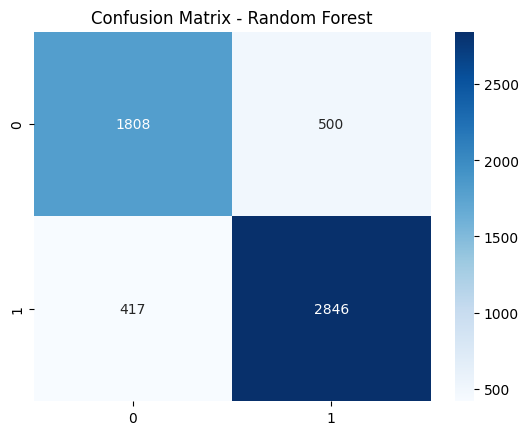

In [5]:
y_pred_rf = rf_model.predict(X_test)
print("Random Forest:\n")
# print(classification_report(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

### 1.3: Lưu mô hình RF

In [6]:
joblib.dump(rf_model, "../models/rf_model.pkl")
print("Đã lưu rf_model.pkl")
# Lưu danh sách tên cột để dùng khi predict
feature_order = X_train.columns.tolist()
joblib.dump(feature_order, '../models/feature_order.pkl')

Đã lưu rf_model.pkl


['../models/feature_order.pkl']

## 2: Huấn luyện LightGBM

### 2.1: Train LightGBM

In [7]:
lgbm_model = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=7
)
lgbm_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 13052, number of negative: 9232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 22284, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585712 -> initscore=0.346266
[LightGBM] [Info] Start training from score 0.346266


LGBMClassifier(learning_rate=0.05, max_depth=7, random_state=42)

### 2.2: Đánh giá LightGBM

LightGBM:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      2308
           1       0.86      0.87      0.87      3263

    accuracy                           0.84      5571
   macro avg       0.84      0.83      0.83      5571
weighted avg       0.84      0.84      0.84      5571



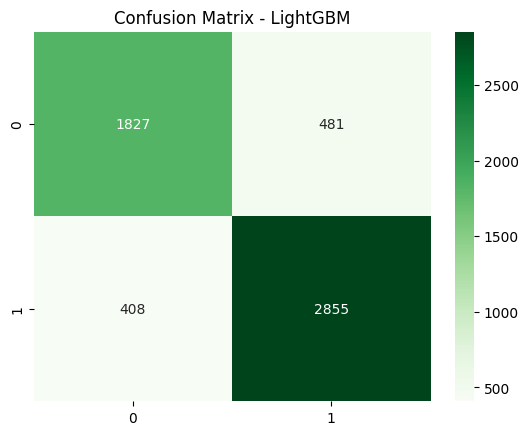

In [8]:
y_pred_lgbm = lgbm_model.predict(X_test)
print("LightGBM:")
print(classification_report(y_test, y_pred_lgbm))
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - LightGBM")
plt.show()

### 2.3: Lưu mô hình LightGBM

In [9]:
joblib.dump(lgbm_model, "../models/lgbm_model.pkl")
print("Đã lưu LightGBM vào models/lgbm_model.pkl")
feature_order = X_train.columns.tolist()
joblib.dump(feature_order, '../models/feature_order_lightgbm.pkl')

Đã lưu LightGBM vào models/lgbm_model.pkl


['../models/feature_order_lightgbm.pkl']

## 3: Huấn luyện Neural Network (MLPClassifier)

### 3.1: Train Neural Net (MLP)

In [10]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64), 
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
mlp_model.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

### 3.2: Đánh giá MLP

Neural Net (MLPClassifier):
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      2308
           1       0.85      0.82      0.83      3263

    accuracy                           0.81      5571
   macro avg       0.80      0.81      0.80      5571
weighted avg       0.81      0.81      0.81      5571



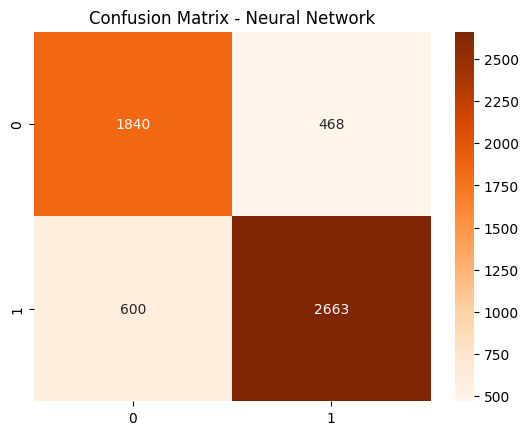

In [11]:
y_pred_mlp = mlp_model.predict(X_test)
print("Neural Net (MLPClassifier):")
print(classification_report(y_test, y_pred_mlp))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Neural Network")
plt.show()

### 3.3: Lưu mô hình MLP

In [12]:
joblib.dump(mlp_model, "../models/nn_model.pkl")
print("Đã lưu Neural Network vào models/nn_model.pkl")

Đã lưu Neural Network vào models/nn_model.pkl
